# 4. Étude des clusters

In [56]:
# Choix des vecteurs
doc_vectors = nmf_doc_vectors
top10words = top10words_nmf
word_vectors = nmf_word_vectors

In [57]:
# Choix de l'lagorithme de clustering
clusters  = kmeans_clusters

In [60]:
# Clusters sous forme de dicitonnaire
dc = dict()
for i,c in enumerate(clusters) :
    if c in dc :
        dc[c].append(i)
    else:
        dc[c] = [i]
        
# Puis le dataframe des tailles et inerties
cc = Counter(clusters)
dfclusters = pd.DataFrame(cc.values(),cc.keys(),columns = ['taille'])
dfclusters['inertie'] = [pdist(doc_vectors[dc[ic]],'cosine').mean() if len(dc[ic])>1 else 0 for ic in dc ]

Taille moyenne : 23.16, std :44.678119924634245


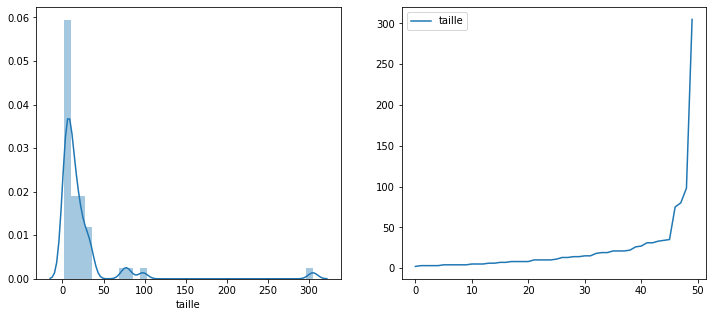

In [61]:
# Afficher la taille des groupes
fig, axes = plt.subplots(1,2,figsize = (12,5))
sns.distplot(dfclusters.taille,ax = axes[0])
dfclusters[dfclusters.taille > 0].sort_values(by='taille').reset_index().plot(y='taille',ax= axes[1])
print('Taille moyenne : {}, std :{}'.format(np.mean(list(cc.values())), np.std(list(cc.values()))))

Inertie moyenne : 0.127227, std :0.162163


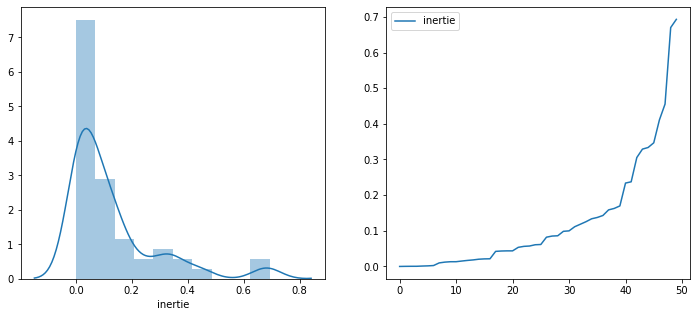

In [62]:
# Afficher l'inertie des groupes
fig, axes = plt.subplots(1,2,figsize = (12,5))
sns.distplot(dfclusters['inertie'] ,ax = axes[0])
dfclusters[dfclusters.taille > 0].sort_values(by='inertie').reset_index().plot(y='inertie',ax= axes[1])
print('Inertie moyenne : {:2f}, std :{:2f}'.format(dfclusters['inertie'] .mean(), dfclusters['inertie'] .std()))

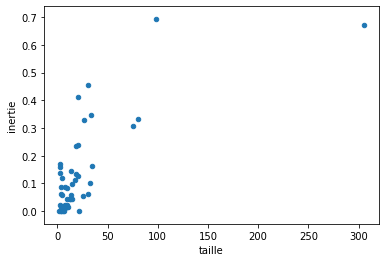

In [63]:
dfclusters.plot.scatter('taille','inertie')

In [64]:
# Quelques groupes avec plus de 1 individu
[g for g in cc if cc[g] >1][:15]

[4, 6, 31, 33, 32, 42, 29, 1, 40, 9, 34, 5, 38, 13, 43]

In [66]:
# Pureté en rubriques
dico_purete = {i:len(dfhi.rubrique[dc[i]].unique()) for i in dc}
list_purete = list(dico_purete.values())
print('Pureté en rubriques moyenne : {:2f} et std : {:2f}'.format(np.mean(list_purete),np.std(list_purete)))
Counter(list_purete)

Pureté en rubriques moyenne : 1.460000 et std : 0.853464


Counter({3: 3, 4: 1, 5: 1, 1: 35, 2: 10})

In [68]:
# Choisir un numéo de cluster
num_clust = 10
indices = np.array([i for i,t in enumerate(clusters) if t == num_clust])
inertie = pdist(doc_vectors[indices],'cosine').mean()
print('{} individus pour une distance moyenne de {:2f} dans le cluster {} '.format(len(indices),inertie,num_clust))

5 individus pour une distance moyenne de 0.002612 dans le cluster 10 


In [69]:
# Obtenir la ditance maximale au sein cluster
def mat_to_ind(mi,n):
    return mi//n,mi%n
mat = squareform(pdist(doc_vectors[dc[num_clust]],'cosine'))
li1,li2 = mat_to_ind(mat.argmax(),len(mat))
l1,l2 = dc[num_clust][li1], dc[num_clust][li2]
print('Distance : {}'.format(mat.max()))
dfhi.loc[[l1,l2],['titre','date_question','groupe_auteur']]

Distance : 0.005771564882440239


,titre,date_question,groupe_auteur
649,cancer rare péritoine,2019-02-12,LAREM
793,accès soin patient atteindre tumeur rare périt...,2019-06-11,LAREM


In [71]:
# Titres des bails
[dfhi.titre[i] for i in indices]

['cancer rare péritoine',
 'situation personne atteindre cancer rare péritoine',
 'prise charge cancer péritoine',
 'fermeture centre recherche maladie rare péritoine',
 'accès soin patient atteindre tumeur rare péritoine']

In [72]:
# On obtient le centroid correspondants 
centroid = doc_vectors[indices].mean(axis = 0)
# centroid_acp_tfidf = reduced_features_tfidf[indices].mean(axis = 0)

In [73]:
# Les meilleurs topics et leurs mots caractéristiques
{centroid[i] : top10words[i] for i in (-centroid).argsort()[:5]}

{0.766160055201128: array(['péritoine', 'rare', 'centre', 'référence', 'charge',
        'lariboisièr', 'prise', 'fermeture', 'tumeur', 'patient'],
       dtype='<U23'),
 0.041436766789567966: array(['000', 'parfaitement', 'parfois', 'parfum', 'parfumer', 'paris',
        'paritaire', 'parfait', 'parité', 'parkinson'], dtype='<U23'),
 0.010463494042255874: array(['cancer', 'enfant', 'pédiatrique', 'recherche', 'financement',
        '500', 'décès', 'parent', 'adolescent', 'allouer'], dtype='<U23'),
 0.009339868951803035: array(['000', 'parfaitement', 'parfois', 'parfum', 'parfumer', 'paris',
        'paritaire', 'parfait', 'parité', 'parkinson'], dtype='<U23'),
 0.008733659044289018: array(['auteur', 'cotisation', 'augmentation', 'cotiser', 'culture',
        'production', 'compenser', 'euro', 'premier', 'frais'],
       dtype='<U23')}

In [74]:
# Mots calculés à l'aide du produit
centroid_dot = np.dot(centroid,word_vectors)
centroid_dot_index = (-centroid_dot).argsort()
tfidf_feature_names[centroid_dot_index][:30]

array(['péritoine', 'rare', 'centre', 'référence', 'charge',
       'lariboisièr', 'prise', 'fermeture', 'tumeur', 'patient', 'réseau',
       'hôpital', 'renape', 'cancer', 'atteindre', 'hospitalier',
       'équipe', 'amarape', 'octobre', 'lit', '31', 'soin', 'expertise',
       'suivi', 'solution', 'réduction', 'structuration', 'groupement',
       'assurer', 'offre'], dtype='<U23')

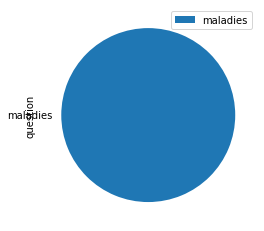

In [75]:
# Les rubriques du clusters
dfh.reset_index(drop = True).loc[indices].groupby('rubrique').count().plot.pie(y='question')

* nmf 100
* kmeans 200
* num 17
* ENA